In [1]:
import numpy as np
import pandas as pd
from pypfopt import EfficientFrontier,risk_models,expected_returns,objective_functions
from pypfopt.base_optimizer import BaseConvexOptimizer
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [2]:
df_info = pd.read_excel('trading-game-data-15112023.xlsx',sheet_name='info')
df_price = pd.read_excel('trading-game-data-15112023.xlsx',sheet_name='price')
df_price['Date'] = pd.to_datetime(df_price['Date'])
df_price.set_index('Date', inplace=True)
df_sp = pd.read_excel('trading-game-data-15112023.xlsx',sheet_name='index-price' )
df_sp['Date'] = pd.to_datetime(df_sp['Date'])
df_sp.set_index('Date', inplace=True)
df_size = pd.read_excel('trading-game-data-15112023.xlsx',sheet_name='size' )
df_size['Date'] = pd.to_datetime(df_size['Date'])
df_size.set_index('Date', inplace=True)
df_ptb = pd.read_excel('trading-game-data-15112023.xlsx',sheet_name='price-to-book' )
df_ptb['Date'] = pd.to_datetime(df_ptb['Date'])
df_ptb.set_index('Date', inplace=True)
df_turnover = df_size = pd.read_excel('trading-game-data-15112023.xlsx',sheet_name='turnover' )
df_turnover['Date'] = pd.to_datetime(df_turnover['Date'])
df_turnover.set_index('Date', inplace=True)
df_vix = pd.read_csv('VIX_history.csv')
df_vix['DATE'] = pd.to_datetime(df_vix['DATE'])
df_vix.set_index('DATE', inplace=True)

In [3]:
log_returns = np.log(df_price / df_price.shift(1))

In [4]:
df_ff = pd.DataFrame()
df_ff['mktrf'] = np.round(np.log(df_sp['S&P 500'] / df_sp['S&P 500'].shift(1))-0.0002,4)
df_ff['SMB']=0
df_ff['HML']=0

In [5]:
for i in range(len(df_size)):
    row_index = df_size.index[i]
    SV = []
    SN = []
    SG = []
    BV = []
    BN = []
    BG = []
    for j in range(len(df_size.columns)):
        if df_size.iloc[i,j] >= df_size.iloc[i].quantile(0.5):
            if df_ptb.iloc[i,j] >= df_ptb.iloc[i].quantile(0.7):
                SG.append(df_size.columns[j])
            elif df_ptb.iloc[i,j] <= df_ptb.iloc[i].quantile(0.3):
                SV.append(df_size.columns[j])
            else:
                SN.append(df_size.columns[j])
        else:
            if df_ptb.iloc[i,j] >= df_ptb.iloc[i].quantile(0.7):
                BG.append(df_size.columns[j])
            elif df_ptb.iloc[i,j] <= df_ptb.iloc[i].quantile(0.3):
                BV.append(df_size.columns[j])
            else:
                BN.append(df_size.columns[j])
                
    SVR = log_returns.loc[row_index,SV].mean()
    SNR = log_returns.loc[row_index,SN].mean()
    SGR = log_returns.loc[row_index,SG].mean()
    BVR = log_returns.loc[row_index,BV].mean()
    BNR = log_returns.loc[row_index,BN].mean()
    BGR = log_returns.loc[row_index,BG].mean()
   
    df_ff['SMB'].iloc[i] = np.round(1/3*(SVR + SNR + SGR)- 1/3 * (BVR + BNR + BGR),4)
    df_ff['HML'].iloc[i] = np.round(1/2*(SVR + BVR)- 1/2 * (BGR + SGR),4)

C:\Users\Jiaqi\AppData\Local\Temp\ipykernel_4396\2030775510.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ff['SMB'].iloc[i] = np.round(1/3*(SVR + SNR + SGR)- 1/3 * (BVR + BNR + BGR),4)
C:\Users\Jiaqi\AppData\Local\Temp\ipykernel_4396\2030775510.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ff['HML'].iloc[i] = np.round(1/2*(SVR + BVR)- 1/2 * (BGR + SGR),4)


In [6]:
df_vix['SENTIMENT'] = df_vix['CLOSE'].shift(1)
sentiment_index = df_vix['SENTIMENT'][(df_vix.index >= '2023-01-01') & (df_vix.index <= '2023-11-14')]

In [7]:
df_ffr = df_ff.join([sentiment_index, log_returns])
#df_ffr = df_ffr.fillna(-1)

In [8]:
# window_size = 30
# step_size = 15
# rolling = pd.DataFrame(columns=['stock','start','end' 'Beta_mktrf', 'Beta_SMB', 'Beta_HML', 'T-stat_mktrf', 'T-stat_SMB', 'T-stat_HML'])
# for j in range(3,len(df_ffr.columns)):
#     for i in range(1, len(df_ffr) - window_size + 1 - 60, step_size):
#         window = df_ffr.iloc[i:i + window_size]
#         X = window[['mktrf', 'SMB', 'HML']]
#         X = sm.add_constant(X) 
#         y = window.iloc[:, j]
#         model = sm.OLS(y, X).fit()

#         beta_mktrf = model.params['mktrf']
#         beta_SMB = model.params['SMB']
#         beta_HML = model.params['HML']
#         t_stat_mktrf = model.tvalues['mktrf']
#         t_stat_SMB = model.tvalues['SMB']
#         t_stat_HML = model.tvalues['HML']

#         start_date = window.index[0]
#         end_date = window.index[-1]
#         rolling.loc[len(rolling)] = [window.columns[j],start_date,end_date, beta_mktrf, beta_SMB, beta_HML, t_stat_mktrf, t_stat_SMB, t_stat_HML]

In [9]:
df_ffr

,mktrf,SMB,HML,SENTIMENT,A,AAL,AAPL,ABBV,ABNB,ABT,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2022-12-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-03,-0.0042,-0.0040,0.0016,21.67,0.002603,0.001571,-0.038122,0.004753,-0.007042,-0.001915,...,0.037368,-0.000571,-0.034965,0.026346,0.001717,-0.008783,-0.001727,0.014673,-0.014342,0.002045
2023-01-04,0.0073,-0.0004,0.0091,22.90,0.010805,0.064588,0.010261,0.008035,0.044011,0.014765,...,0.059958,0.008526,0.002906,0.032800,-0.001536,0.013457,0.009228,0.010665,0.035874,0.014266
2023-01-05,-0.0119,0.0055,0.0068,22.01,0.002897,0.029009,-0.010661,-0.001223,-0.011449,-0.003694,...,0.004829,-0.020442,0.022127,-0.020638,-0.028804,-0.007645,-0.018701,-0.011204,-0.017675,-0.023845
2023-01-06,0.0224,-0.0023,-0.0010,22.46,-0.029624,0.013490,0.036133,0.018544,0.009193,0.013714,...,0.024121,0.029177,0.012014,0.010223,0.034934,0.020079,-0.003019,0.050097,0.037973,0.014944
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-08,0.0008,-0.0021,-0.0113,14.81,-0.010458,0.021886,0.005868,-0.000915,-0.028652,-0.000633,...,-0.003009,-0.012615,-0.012359,-0.025679,0.000413,0.001035,-0.010152,-0.007721,-0.010021,0.021952
2023-11-09,-0.0083,0.0004,-0.0026,14.45,-0.015199,-0.021886,-0.002628,-0.028495,-0.018355,-0.012640,...,-0.024518,-0.006453,0.000291,-0.015657,0.000103,-0.007191,-0.007082,-0.019171,-0.036499,-0.001406
2023-11-10,0.0153,0.0035,-0.0043,15.29,0.006753,0.004246,0.021638,0.003976,0.022511,0.004480,...,-0.058607,0.008482,0.007644,0.040983,0.016797,0.009894,0.012408,0.017911,0.011303,-0.007707


In [10]:
ff_coeff = pd.DataFrame(columns=['stock','start','end', 'const','Beta_mktrf', 'Beta_SMB', 'Beta_HML', 'T-stat_mktrf', 'T-stat_SMB', 'T-stat_HML'])
ff_return = pd.DataFrame()
for j in range(4,len(df_ffr.columns)):
    window = df_ffr.iloc[1:-1]
    #out_window = df_ffr.iloc[140:-1]
    X = window[['mktrf', 'SMB', 'HML','SENTIMENT']]
    X = sm.add_constant(X) 
    y = window.iloc[:, j]
    model = sm.OLS(y, X).fit()
    
  #  X_pred = out_window[['mktrf', 'SMB', 'HML']]
  #  X_pred = sm.add_constant(X_pred)
    beta_mktrf = model.params['mktrf']
    beta_SMB = model.params['SMB']
    beta_HML = model.params['HML']
    beta_SENTIMENT = model.params['SENTIMENT']
    t_stat_mktrf = model.tvalues['mktrf']
    t_stat_SMB = model.tvalues['SMB']
    t_stat_HML = model.tvalues['HML']
    t_stat_SENTIMENT = model.tvalues['SENTIMENT']
    intercept = model.params['const']
    
    y_pred = model.predict(X)
    ff_return[df_ffr.columns[j]] = y_pred
    
    start_date = window.index[0]
    end_date = window.index[-1]
    ff_coeff.loc[len(ff_coeff)] = [window.columns[j],start_date,end_date,intercept, beta_mktrf, beta_SMB, beta_HML, t_stat_mktrf, t_stat_SMB, t_stat_HML]

C:\Users\Jiaqi\AppData\Local\Temp\ipykernel_4396\3137465391.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ff_return[df_ffr.columns[j]] = y_pred
C:\Users\Jiaqi\AppData\Local\Temp\ipykernel_4396\3137465391.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ff_return[df_ffr.columns[j]] = y_pred
C:\Users\Jiaqi\AppData\Local\Temp\ipykernel_4396\3137465391.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining a

C:\Users\Jiaqi\AppData\Local\Temp\ipykernel_4396\3137465391.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ff_return[df_ffr.columns[j]] = y_pred
C:\Users\Jiaqi\AppData\Local\Temp\ipykernel_4396\3137465391.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ff_return[df_ffr.columns[j]] = y_pred
C:\Users\Jiaqi\AppData\Local\Temp\ipykernel_4396\3137465391.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining a

C:\Users\Jiaqi\AppData\Local\Temp\ipykernel_4396\3137465391.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ff_return[df_ffr.columns[j]] = y_pred
C:\Users\Jiaqi\AppData\Local\Temp\ipykernel_4396\3137465391.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ff_return[df_ffr.columns[j]] = y_pred
C:\Users\Jiaqi\AppData\Local\Temp\ipykernel_4396\3137465391.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining a

C:\Users\Jiaqi\AppData\Local\Temp\ipykernel_4396\3137465391.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ff_return[df_ffr.columns[j]] = y_pred
C:\Users\Jiaqi\AppData\Local\Temp\ipykernel_4396\3137465391.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ff_return[df_ffr.columns[j]] = y_pred
C:\Users\Jiaqi\AppData\Local\Temp\ipykernel_4396\3137465391.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining a

C:\Users\Jiaqi\AppData\Local\Temp\ipykernel_4396\3137465391.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ff_return[df_ffr.columns[j]] = y_pred
C:\Users\Jiaqi\AppData\Local\Temp\ipykernel_4396\3137465391.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ff_return[df_ffr.columns[j]] = y_pred
C:\Users\Jiaqi\AppData\Local\Temp\ipykernel_4396\3137465391.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining a

C:\Users\Jiaqi\AppData\Local\Temp\ipykernel_4396\3137465391.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ff_return[df_ffr.columns[j]] = y_pred
C:\Users\Jiaqi\AppData\Local\Temp\ipykernel_4396\3137465391.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ff_return[df_ffr.columns[j]] = y_pred
C:\Users\Jiaqi\AppData\Local\Temp\ipykernel_4396\3137465391.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining a

C:\Users\Jiaqi\AppData\Local\Temp\ipykernel_4396\3137465391.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ff_return[df_ffr.columns[j]] = y_pred
C:\Users\Jiaqi\AppData\Local\Temp\ipykernel_4396\3137465391.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ff_return[df_ffr.columns[j]] = y_pred
C:\Users\Jiaqi\AppData\Local\Temp\ipykernel_4396\3137465391.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining a

C:\Users\Jiaqi\AppData\Local\Temp\ipykernel_4396\3137465391.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ff_return[df_ffr.columns[j]] = y_pred
C:\Users\Jiaqi\AppData\Local\Temp\ipykernel_4396\3137465391.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ff_return[df_ffr.columns[j]] = y_pred
C:\Users\Jiaqi\AppData\Local\Temp\ipykernel_4396\3137465391.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining a

C:\Users\Jiaqi\AppData\Local\Temp\ipykernel_4396\3137465391.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ff_return[df_ffr.columns[j]] = y_pred
C:\Users\Jiaqi\AppData\Local\Temp\ipykernel_4396\3137465391.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ff_return[df_ffr.columns[j]] = y_pred
C:\Users\Jiaqi\AppData\Local\Temp\ipykernel_4396\3137465391.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining a

In [11]:
ff_return = ff_return.fillna(-1)

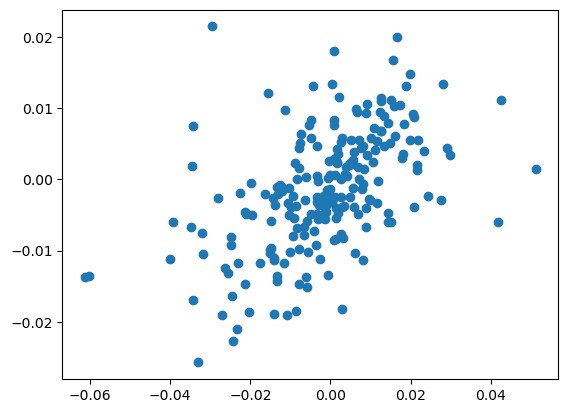

In [23]:
plt.scatter(log_returns[1:219].A,ff_return.A)

In [27]:
mu = expected_returns.mean_historical_return(ff_return, log_returns=True,frequency=252,compounding=False,returns_data = True)
S = risk_models.sample_cov(ff_return, log_returns=True,frequency=252,returns_data = True)

rf = 0.05

def optm_func(weights, expected_return, cov_matrix,rf):
    portfolio_risk = np.sqrt(np.dot(weights, np.dot(cov_matrix, weights)))
    portfolio_return = weights @ expected_return
    sharpe_ratio = (portfolio_return - rf) / portfolio_risk
    return -sharpe_ratio

constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1},
               {'type': 'ineq', 'fun': lambda weights: weights},
              {'type': 'ineq', 'fun': lambda weights: 0.1-weights})

n_assets = len(mu)
bounds = [(0, 1) for _ in range(n_assets)]
initial_weights = np.ones(n_assets) / n_assets

optimization = minimize(optm_func, initial_weights, args=(mu, S, rf),
                constraints=constraints, bounds=bounds)
optimal_weights = optimization.x
optimal_return = optimal_weights @ mu
optimal_risk = np.sqrt(optimal_weights @ S @ optimal_weights)
optimal_sharpe_ratio = (optimal_return - rf) / optimal_risk
optimal_weights = np.round(optimal_weights,4)

optimal_sharpe = (optimal_return - rf) / optimal_risk

print(optimal_weights)
print("Optimal Portfolio Return:", optimal_return)
print("Optimal Portfolio Risk:", optimal_risk)
print("Optimal Sharpe Ratio:", optimal_sharpe)

C:\Users\Jiaqi\AppData\Roaming\Python\Python311\site-packages\pypfopt\risk_models.py:70: UserWarning: The covariance matrix is non positive semidefinite. Amending eigenvalues.
  warnings.warn(
C:\Users\Jiaqi\AppData\Roaming\Python\Python311\site-packages\pypfopt\risk_models.py:89: UserWarning: Could not fix matrix. Please try a different risk model.
  warnings.warn(


[0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.1    0.
 0.     0.     0.1    0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.1    0.     0.     0.     0.     0.     0.
 0.     0.     0.1    0.     0.     0.     0.     0.     0.     0.
 0.     0.1    0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.   

In [29]:
np.savetxt("weights5.txt", optimal_weights,fmt='%.5f')

In [30]:
ef = EfficientFrontier(mu, S,solver="ECOS")
raw_weights = ef.max_sharpe(risk_free_rate=0.05)
cleaned_weights = list(ef.clean_weights().values())
print(cleaned_weights)
ef.portfolio_performance(verbose=True,risk_free_rate=0.05)
ef.save_weights_to_file('weights5.csv')

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.78652, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 